In [1]:
# Import necessary libraries for data handling, machine learning, and visualisation
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import json
import datetime
import time
import pandas as pd
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Define a function to load a CSV file into a list of dictionaries
import csv

def load_csv(filename):
    lines = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
# Load the stroke prediction dataset from a CSV file
data = load_csv("healthcare-dataset-stroke-data.csv")

In [4]:
# Explore the dataset to understand its structure
print(len(data))
print(data[0])
print(len(data[0]))
print(data[0].keys())
print(data[0].values())
print(data[0]['age'])
print(data[0]['avg_glucose_level'])

5110
{'id': '9046', 'gender': 'Male', 'age': '67', 'hypertension': '0', 'heart_disease': '1', 'ever_married': 'Yes', 'work_type': 'Private', 'Residence_type': 'Urban', 'avg_glucose_level': '228.69', 'bmi': '36.6', 'smoking_status': 'formerly smoked', 'stroke': '1'}
12
dict_keys(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'])
dict_values(['9046', 'Male', '67', '0', '1', 'Yes', 'Private', 'Urban', '228.69', '36.6', 'formerly smoked', '1'])
67
228.69


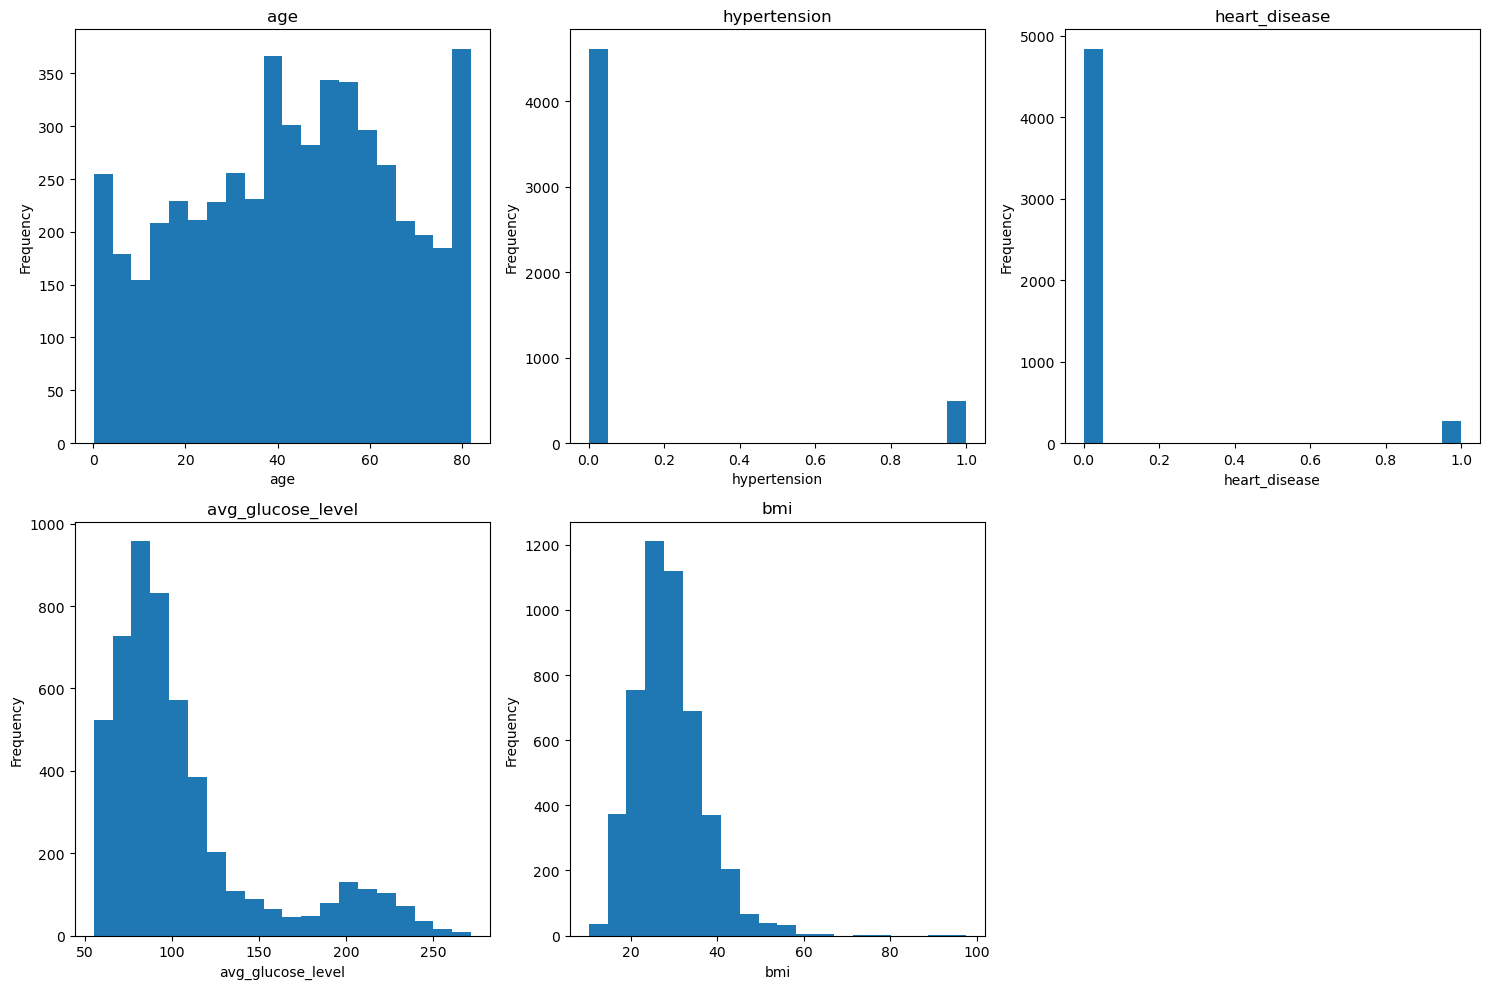

In [5]:
# Identify numerical features in the dataset by excluding non-numerical and target columns
numerical_features = [key for key in data[0].keys() if key not in ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']]

# Calculate the number of numerical features to plot
num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Iterate over each numerical feature to create a histogram
for i, feature in enumerate(numerical_features):
    try:
        values = [float(item[feature]) for item in data if item[feature] != 'N/A']
        axes[i].hist(values, bins=20)
        axes[i].set_title(feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
    except (ValueError, TypeError):
        print(f"Skipping {feature} due to non-numeric or invalid values")
    except IndexError:
        pass

for j in range(i+1, len(axes)):
    axes[j].axis('off')


plt.tight_layout()
plt.show()

In [6]:
# Define the Dense Neural Network (Dense NN) model for stroke prediction
class DenseNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DenseNN, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Define the Convolutional Neural Network (CNN) model for stroke prediction
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool1d(2)

        conv_output_size = (input_size // 4) * 32

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [17]:
# Define a class to track and save model training progress
class ModelTracker:
    def __init__(self, model_name, base_dir='model_outputs'):
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        self.model_name = model_name

        self.base_dir = Path(base_dir)
        self.run_dir = self.base_dir / f"{model_name}_{self.timestamp}"
        self.run_dir.mkdir(parents=True, exist_ok=True)

        self.metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'train_f1': [],
            'test_accuracy': [],
            'test_f1': [],
            'epoch_times': []
        }

# Method to update the metrics dictionary with new values for the current epoch
    def update_metrics(self, epoch_metrics):
        for key, value in epoch_metrics.items():
            self.metrics[key].append(value)

# Method to save the model's state, optimizer state, and metrics to a checkpoint file
    def save_model(self, model, optimizer):
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': self.metrics
        }
        torch.save(checkpoint, self.run_dir / 'model_checkpoint.pth')

    def save_metrics(self):
        with open(self.run_dir / 'metrics.json', 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def save_config(self, config):
        with open(self.run_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)


def plot_metrics(tracker, save_dir):

    

   
    plt.figure(figsize=(8, 6))
    precision = tracker.metrics['precision_history'][-1]
    recall = tracker.metrics['recall_history'][-1]
    plt.scatter([recall], [precision], color='blue', s=100, label='Operating Point')
    plt.plot([0, 1], [precision, precision], '--', color='gray', label='Precision Line')
    plt.plot([recall, recall], [0, 1], '--', color='gray', label='Recall Line')
    plt.title(f'{tracker.model_name} Precision-Recall Point')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.savefig(save_dir / 'precision_recall.png')
    plt.show()
   
# Define a function to train and evaluate a model
def train_evaluate_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                        config):
    from sklearn.metrics import f1_score, precision_recall_curve

    tracker = ModelTracker(model.__class__.__name__)
    tracker.save_config(config)
    
# Define the loss function with class weights to handle imbalanced data
    class_counts = torch.bincount(y_train_tensor)
    total_samples = len(y_train_tensor)
    class_weights = total_samples / (2 * class_counts)
    class_weights = class_weights / class_weights.sum()

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    precision_history = []
    recall_history = []

# Training loop over the specified number of epochs
    for epoch in range(config['num_epochs']):
        model.train()
        start_time = datetime.datetime.now()

        optimizer.zero_grad()
        train_outputs = model(X_train_tensor)
        loss = criterion(train_outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval() # Set the model to evaluation mode (disables dropout, batch norm updates)
        with torch.no_grad():
            train_preds = torch.argmax(train_outputs, dim=1)
            train_acc = accuracy_score(y_train_tensor, train_preds)
            train_f1 = f1_score(y_train_tensor, train_preds)

            test_outputs = model(X_test_tensor)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = accuracy_score(y_test_tensor, test_preds)
            test_f1 = f1_score(y_test_tensor, test_preds)

            current_precision = precision_score(y_test_tensor, test_preds)
            current_recall = recall_score(y_test_tensor, test_preds)
            precision_history.append(current_precision)
            recall_history.append(current_recall)

# Compile epoch metrics into a dictionary
        epoch_metrics = {
            'train_loss': loss.item(),
            'train_accuracy': train_acc,
            'train_f1': train_f1,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'epoch_times': (datetime.datetime.now() - start_time).total_seconds()
        }
        tracker.update_metrics(epoch_metrics)

# Print metrics every 2 epochs for monitoring progress
        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, '
                  f'Test Acc: {test_acc:.4f}, '
                  f'Train F1: {train_f1:.4f}, '
                  f'Test F1: {test_f1:.4f}')

# Final evaluation after training is complete
    model.eval()
    with torch.no_grad():
        final_outputs = model(X_test_tensor)
        final_preds = torch.argmax(final_outputs, dim=1)

# Compute final metrics on the test set
        final_metrics = {
            'accuracy': accuracy_score(y_test_tensor, final_preds),
            'recall': recall_score(y_test_tensor, final_preds),
            'precision': precision_score(y_test_tensor, final_preds),
            'f1_score': f1_score(y_test_tensor, final_preds),
            'final_confusion_matrix': confusion_matrix(y_test_tensor, final_preds).tolist(),
            'precision_history': precision_history,
            'recall_history': recall_history
        }

# Update the tracker's metrics with the final metrics and save results
        tracker.metrics.update(final_metrics)
        tracker.save_metrics()
        tracker.save_model(model, optimizer)
        plot_metrics(tracker, tracker.run_dir)

        return tracker.metrics

# Define a function to compare and save results of CNN and DNN models
def plot_model_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'recall', 'precision', 'f1_score']
    values = {
        'CNN': [cnn_metrics[m] for m in metrics],
        'Dense NN': [dense_metrics[m] for m in metrics]
    }

    

    comparison_results = {
        'CNN': cnn_metrics,
        'Dense NN': dense_metrics
    }
    with open(comparison_dir / 'comparison_results.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)

C:\Users\ayoos\AppData\Local\Temp\ipykernel_5164\3296701337.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)
C:\Users\ayoos\AppData\Local\Temp\ipykernel_5164\3296701337.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa


Dataset Information:
Training samples: 4088
Testing samples: 1022
Number of features: 10
Class distribution in training set:
stroke
0    0.953523
1    0.046477
Name: proportion, dtype: float64

Training CNN Model
Epoch [2/400], Loss: 0.6574, Train Acc: 0.3195, Test Acc: 0.8434, Train F1: 0.1095, Test F1: 0.2593
Epoch [4/400], Loss: 0.6253, Train Acc: 0.6500, Test Acc: 0.8493, Train F1: 0.1762, Test F1: 0.2667
Epoch [6/400], Loss: 0.5694, Train Acc: 0.7872, Test Acc: 0.6605, Train F1: 0.2204, Test F1: 0.2473
Epoch [8/400], Loss: 0.5689, Train Acc: 0.5827, Test Acc: 0.6341, Train F1: 0.1702, Test F1: 0.2305
Epoch [10/400], Loss: 0.5425, Train Acc: 0.6744, Test Acc: 0.7339, Train F1: 0.1909, Test F1: 0.2804
Epoch [12/400], Loss: 0.5256, Train Acc: 0.7221, Test Acc: 0.7329, Train F1: 0.2089, Test F1: 0.2759
Epoch [14/400], Loss: 0.5294, Train Acc: 0.6720, Test Acc: 0.6507, Train F1: 0.1927, Test F1: 0.2355
Epoch [16/400], Loss: 0.5145, Train Acc: 0.6301, Test Acc: 0.6546, Train F1: 0.1827

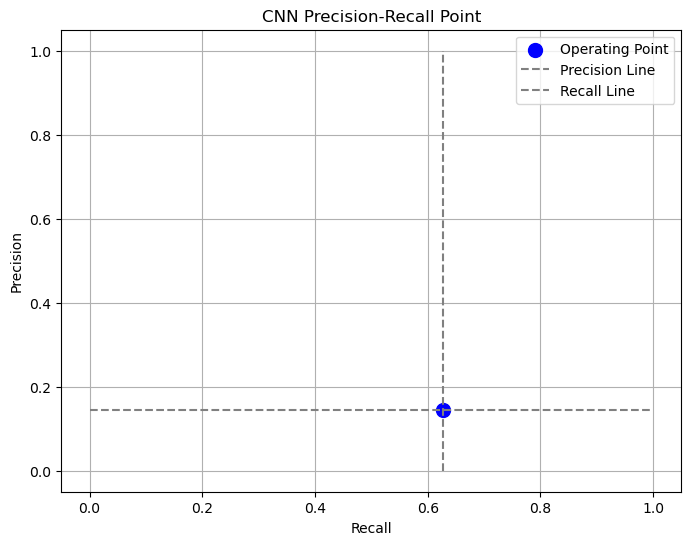

CNN Training Time: 11.19 seconds

Training Dense Neural Network
Epoch [2/400], Loss: 0.5906, Train Acc: 0.5345, Test Acc: 0.1761, Train F1: 0.1516, Test F1: 0.1229
Epoch [4/400], Loss: 0.5614, Train Acc: 0.5736, Test Acc: 0.4599, Train F1: 0.1616, Test F1: 0.1737
Epoch [6/400], Loss: 0.5452, Train Acc: 0.6159, Test Acc: 0.6067, Train F1: 0.1711, Test F1: 0.2209
Epoch [8/400], Loss: 0.5047, Train Acc: 0.6504, Test Acc: 0.6429, Train F1: 0.1867, Test F1: 0.2348
Epoch [10/400], Loss: 0.4913, Train Acc: 0.6734, Test Acc: 0.6575, Train F1: 0.1904, Test F1: 0.2391
Epoch [12/400], Loss: 0.4835, Train Acc: 0.6942, Test Acc: 0.6605, Train F1: 0.2048, Test F1: 0.2407
Epoch [14/400], Loss: 0.4760, Train Acc: 0.6915, Test Acc: 0.6575, Train F1: 0.2054, Test F1: 0.2325
Epoch [16/400], Loss: 0.4740, Train Acc: 0.6842, Test Acc: 0.6644, Train F1: 0.1956, Test F1: 0.2327
Epoch [18/400], Loss: 0.4530, Train Acc: 0.6891, Test Acc: 0.6712, Train F1: 0.2081, Test F1: 0.2329
Epoch [20/400], Loss: 0.4693, T

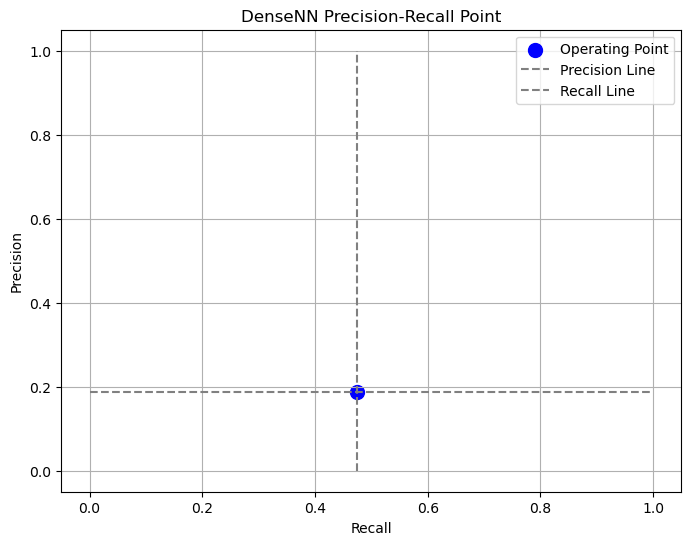

Dense Neural Network Training Time: 10.41 seconds

CNN Final Results:
----------------------------------------
Accuracy: 0.7661
Precision: 0.1457
Recall: 0.6271
F1 Score: 0.2364

Confusion Matrix:
[[746 217]
 [ 22  37]]

Dense Neural Network Final Results:
----------------------------------------
Accuracy: 0.8503
Precision: 0.1867
Recall: 0.4746
F1 Score: 0.2679

Confusion Matrix:
[[841 122]
 [ 31  28]]


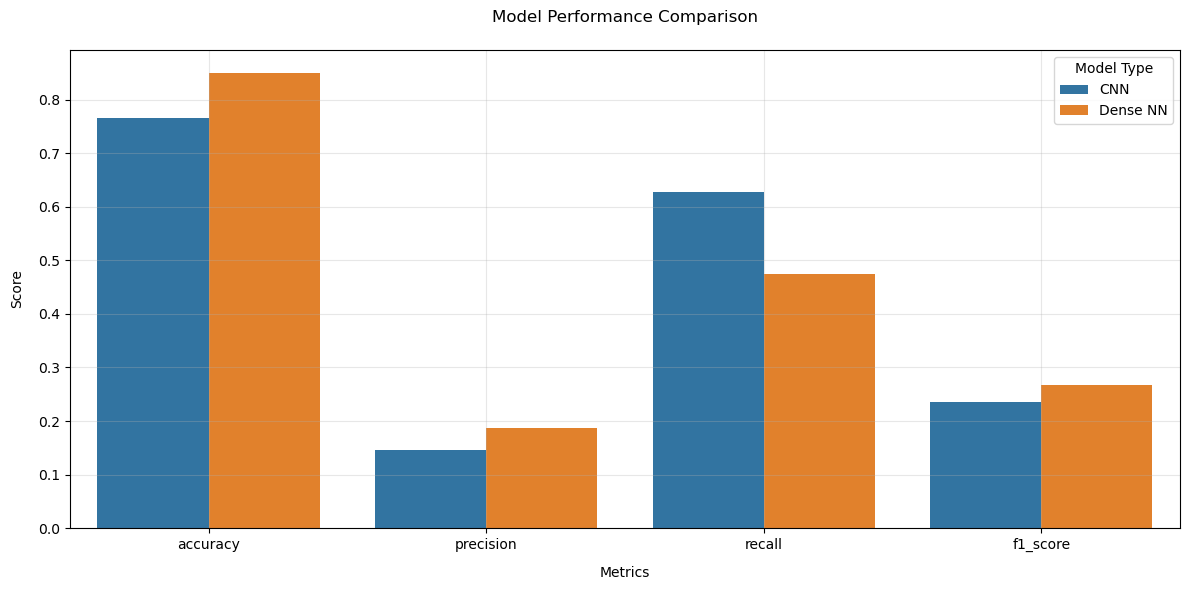


Summary Comparison Table:
   Metric      CNN  Dense NN
 Accuracy 0.766145  0.850294
Precision 0.145669  0.186667
   Recall 0.627119  0.474576
 F1 Score 0.236422  0.267943


In [19]:
# Set random seeds for reproducibility across all libraries
SEED = 41
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load the dataset into a Pandas DataFrame for easier manipulation
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Fill missing 'bmi' values with the mean of the 'bmi' column
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)

# Encode categorical variables into numerical values using LabelEncoder
label_encoders = {}
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop 'stroke' (target) and 'id' (irrelevant) columns from features
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Standardise numerical features to have mean=0 and variance=1
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Convert the data into PyTorch tensors for model training
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print("\nDataset Information:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

# Define configuration parameters for model training
config = {
    'num_epochs': 400,
    'learning_rate': 0.01,
    'batch_size': 32,
    'dropout_rate': 0.3,
    'hidden_sizes': [128, 64, 32],
    'conv_channels': [16, 32],
    'kernel_size': 3
}

input_size = X_train.shape[1]
num_classes = 2

# Train and evaluate the CNN model
print("\nTraining CNN Model")
cnn_model = CNN(input_size, num_classes)

start_time_cnn = time.time()

# Train the model and evaluate it on the test set, returning performance metrics
cnn_metrics = train_evaluate_model(cnn_model, X_train_tensor, y_train_tensor,
                                 X_test_tensor, y_test_tensor, config)
end_time_cnn = time.time()
print(f"CNN Training Time: {end_time_cnn - start_time_cnn:.2f} seconds")

print("\nTraining Dense Neural Network")
dense_model = DenseNN(input_size, num_classes)
start_time_dnn = time.time()

# Train the model and evaluate it on the test set, returning performance metrics
dense_metrics = train_evaluate_model(dense_model, X_train_tensor, y_train_tensor,
                                   X_test_tensor, y_test_tensor, config)
end_time_dnn = time.time()
print(f"Dense Neural Network Training Time: {end_time_dnn - start_time_dnn:.2f} seconds")

# Define a function to print the final results of a model
def print_model_results(model_name, metrics):
    print(f"\n{model_name} Final Results:")
    print("-" * 40)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(np.array(metrics['final_confusion_matrix']))

print_model_results("CNN", cnn_metrics)
print_model_results("Dense Neural Network", dense_metrics)

# Define a function to plot and save a detailed comparison of the two models
def plot_detailed_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    comparison_data = pd.DataFrame({
        'Metric': metrics * 2,
        'Model': ['CNN'] * len(metrics) + ['Dense NN'] * len(metrics),
        'Score': [cnn_metrics[m] for m in metrics] + [dense_metrics[m] for m in metrics]
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_data)
    plt.title('Model Performance Comparison', pad=20)
    plt.xlabel('Metrics', labelpad=10)
    plt.ylabel('Score', labelpad=10)
    plt.legend(title='Model Type')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(comparison_dir / 'detailed_comparison.png')
    plt.show()

    comparison_results = {
        'CNN': {metric: cnn_metrics[metric] for metric in metrics},
        'Dense NN': {metric: dense_metrics[metric] for metric in metrics}
    }

    with open(comparison_dir / 'detailed_comparison.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)

# Plot the comparison between CNN and Dense NN
plot_detailed_comparison(cnn_metrics, dense_metrics)

summary_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'CNN': [cnn_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']],
    'Dense NN': [dense_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']]
})

print("\nSummary Comparison Table:")
print(summary_data.to_string(index=False))